In [1]:
cd ..

/home/wesg/research/neuron-stats


In [2]:
# autoreload
%load_ext autoreload
%autoreload 2

import os
import pickle
import argparse
import einops
import torch
import numpy as np
import pandas as pd
from transformer_lens import HookedTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import datasets
import torch
from analysis.entropy_neurons import *

torch.set_grad_enabled(False)

%matplotlib inline

/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.0.6) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
model_names = ['stanford-gpt2-small-a', 'stanford-gpt2-medium-a', 'pythia-160m']
ndfs = {}
for model_name in model_names:
    neuron_df = pd.read_csv(f'dataframes/neuron_dfs/{model_name}.csv')
    neuron_df['excess_corr'] = neuron_df['mean_corr'] - neuron_df['mean_baseline']
    ndfs[model_name] = neuron_df

In [4]:
ndfs['stanford-gpt2-small-a'].sort_values('vocab_var').query('layer >= 10 and l2_penalty >= 3 and vocab_kurt <= 10 and kurt <= 10').head(30).style.background_gradient(axis=0)

,layer,neuron,max_corr,mean_corr,min_corr,max_baseline,min_baseline,mean_baseline,w_in_norm,input_bias,w_out_norm,in_out_sim,l2_penalty,mean,var,skew,kurt,vocab_mean,vocab_var,vocab_skew,vocab_kurt,sparsity,excess_corr
36822,11,3030,0.761700,0.740875,0.691000,0.228000,0.211200,0.221950,1.339984,-0.001558,2.000657,-0.129749,5.798185,-3.452917,4.400391,0.200399,3.480279,-0.000169,0.000009,-0.134119,3.267792,0.062572,0.518925
36651,11,2859,0.820000,0.743900,0.584000,0.378000,0.291700,0.326175,0.507985,0.215399,2.273104,0.016099,5.425049,-0.552119,0.620203,0.230751,3.562172,-0.000419,0.000049,-0.042253,2.615250,0.251240,0.417725
32740,10,2020,0.777000,0.766125,0.758300,0.246100,0.221400,0.229975,0.484177,-0.203285,1.931489,0.049528,3.965077,-0.617220,0.442695,1.102571,5.805764,-0.000268,0.000049,-0.028250,3.409756,0.190207,0.536150
36338,11,2546,0.562500,0.500250,0.430000,0.376500,0.318400,0.350050,0.403030,-0.077120,1.865874,-0.160157,3.643918,0.065139,0.207073,-0.201227,3.055253,-0.000226,0.000118,0.168612,2.893428,0.649311,0.150200
36540,11,2748,0.728000,0.691000,0.605000,0.294000,0.258300,0.279950,0.781791,0.191072,2.159352,0.009371,5.273998,-0.634973,0.409525,0.382884,2.995612,0.000478,0.000419,-0.361653,3.847452,0.209436,0.411050
36057,11,2265,0.572300,0.479375,0.418200,0.386200,0.322300,0.348525,0.510981,-0.697742,1.743419,0.585905,3.300613,-2.095613,0.247950,0.489890,4.581419,-0.001642,0.007871,-0.279025,7.462216,0.001953,0.130850


In [5]:
ndfs['stanford-gpt2-medium-a'].sort_values('vocab_var').query('layer >= 22 and l2_penalty >= 1 and vocab_kurt <= 8 and kurt <= 10 and vocab_var <= 0.001').head(30).style.background_gradient(axis=0)

,layer,neuron,max_corr,mean_corr,min_corr,max_baseline,min_baseline,mean_baseline,w_in_norm,input_bias,w_out_norm,in_out_sim,l2_penalty,mean,var,skew,kurt,vocab_mean,vocab_var,vocab_skew,vocab_kurt,sparsity,excess_corr
95153,23,945,0.767600,0.757875,0.737300,0.346200,0.318600,0.326300,0.835114,0.718998,1.608204,-0.278377,3.283736,-3.227521,5.813730,0.255745,2.713623,-0.000092,0.000009,-0.109323,3.604302,0.122469,0.431575
95288,23,1080,0.730000,0.709450,0.683000,0.316700,0.260000,0.291575,0.523784,0.480345,1.193657,-0.436162,1.699167,-1.593082,1.397700,0.224852,2.937979,-0.000082,0.000024,0.159333,5.030738,0.116898,0.417875
92183,22,2071,0.680000,0.578625,0.491500,0.395000,0.391000,0.393450,0.563304,0.351596,1.047786,-0.264283,1.415167,1.477078,0.389612,0.289914,3.033502,0.000100,0.000033,0.251979,3.157743,0.997906,0.185175
95903,23,1695,0.780000,0.684350,0.577000,0.381600,0.352000,0.365000,0.479174,0.304325,0.928519,-0.285453,1.091755,-0.549578,0.867448,0.003762,3.415113,-0.000578,0.000116,-0.427148,6.302482,0.308748,0.319350
91656,22,1544,0.748000,0.701500,0.662600,0.510700,0.381300,0.427425,0.556254,-0.014062,1.007065,-0.296556,1.323598,0.564267,0.489834,-0.445719,3.841507,-0.000413,0.000175,0.098648,2.885955,0.844072,0.274075
90796,22,684,0.635000,0.552675,0.479700,0.370000,0.322500,0.342325,0.447699,0.052631,0.927864,-0.125946,1.061365,0.517172,0.385244,-0.451674,3.326646,0.000338,0.000380,-1.098421,3.759513,0.843304,0.210350
91995,22,1883,0.408400,0.304350,0.267000,0.163000,0.157700,0.160125,0.741036,-0.414389,0.772529,0.273201,1.145935,-1.511621,0.416546,0.654693,4.595781,-0.000157,0.000570,0.313024,6.456920,0.024196,0.144225
93497,22,3385,0.389000,0.301750,0.223100,0.200200,0.182400,0.193725,0.653701,-0.406786,0.864320,-0.139959,1.174374,-1.566776,0.413534,0.425464,3.867365,0.000367,0.000694,0.065707,5.783622,0.024019,0.108025
95226,23,1018,0.831000,0.808000,0.793000,0.504000,0.343800,0.410050,0.357208,-0.498215,0.947948,-0.071892,1.026204,-0.243616,0.480954,-0.240515,2.554916,-0.000349,0.000770,0.237619,3.685271,0.444885,0.397950


In [6]:
ndfs['pythia-160m'].sort_values('vocab_var').query('layer >= 10 and vocab_var <= 0.001 and vocab_kurt <= 7 and l2_penalty >= 2').head(30).style.background_gradient(axis=0)

,layer,neuron,max_corr,mean_corr,min_corr,max_baseline,min_baseline,mean_baseline,w_in_norm,input_bias,w_out_norm,in_out_sim,l2_penalty,mean,var,skew,kurt,vocab_mean,vocab_var,vocab_skew,vocab_kurt,sparsity,excess_corr
34862,11,1070,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,1.253549,0.735999,0.742814,-0.465973,2.123158,3.188068,9.287919,1.391351,4.231353,0.000939,0.000593,0.061128,3.126129,0.969691,0.000000
31925,10,1205,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,1.630889,0.917315,1.018975,0.001170,3.698109,-1.013763,9.507114,0.861992,3.207008,0.000142,0.000659,-0.138710,2.985992,0.314848,0.000000
33105,10,2385,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,1.215707,0.500856,1.083370,0.056047,2.651634,0.572068,3.778698,0.736406,3.473579,0.001178,0.000715,0.076798,2.940556,0.583102,0.000000
31908,10,1188,0.000000,0.000000,0.000000,nan,nan,nan,1.450654,0.503916,0.707000,-0.369175,2.604247,4.696265,10.377267,0.695025,3.465466,0.000405,0.000728,-0.178712,3.084060,0.968023,nan
33772,10,3052,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,1.542669,-0.791370,0.492557,-0.501323,2.622439,4.021401,6.917575,-0.095426,3.171933,-0.000390,0.000733,-0.007286,2.994319,0.940332,0.000000
31473,10,753,0.000000,0.000000,0.000000,nan,nan,nan,2.247990,-1.502541,0.471610,-0.440745,5.275877,10.488863,19.635780,-0.982166,3.677336,0.001073,0.000742,0.046744,2.995803,0.974061,nan
33547,10,2827,0.337200,0.297233,0.270500,0.283400,0.243200,0.263433,1.100735,0.201703,0.908862,0.005256,2.037647,-0.495044,2.140448,0.695890,4.269212,-0.001661,0.000747,0.152906,3.211229,0.353050,0.033800
31819,10,1099,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,1.822639,0.856839,0.589336,-0.290521,3.669330,4.034516,16.636105,0.308977,3.047029,0.002156,0.000785,-0.519737,4.173460,0.851351,0.000000
32637,10,1917,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,2.063894,0.780910,0.935200,0.067847,5.134258,1.566075,16.199566,0.858159,3.338681,0.002290,0.000799,-0.448076,3.535024,0.587966,0.000000
31449,10,729,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,1.499708,0.995581,0.653230,-0.432777,2.675832,2.283722,10.686148,1.901518,7.272249,-0.000277,0.000805,-0.152416,2.982730,0.859023,0.000000


In [7]:
neuron_data = {
    "stanford-gpt2-small-a": ['11.3030', '11.2859'],
    "stanford-gpt2-medium-a": ['23.945', '22.2882'],#['23.945', '23.1080', '22.2071', '22.2882'],
    "pythia-160m": ['11.1070', '10.1205', '10.2385']
}

baseline_neuron_data = {
    "stanford-gpt2-small-a": ['11.2652', '11.1602', '10.2129', '10.906', '10.2944', '10.2783', '11.779', '10.2314', '11.1821', '10.1220', '10.2166', '11.1974', '11.2443', '11.2028', '11.127', '10.1971', '11.148', '11.682', '10.2121', '10.684'],
    "stanford-gpt2-medium-a": ['22.3440', '22.2781', '23.3788', '23.3475', '22.1464', '22.2228', '22.987', '23.3974', '23.529', '22.669', '23.1075', '23.3938', '23.1404', '23.53', '22.125', '22.253', '22.2078', '23.188', '22.2548', '22.401'],
    "pythia-160m": ['11.1406', '10.316', '10.2884', '11.2874', '10.1714', '10.351', '11.592', '11.541', '10.2471', '11.1052', '11.1667', '10.2684', '10.97', '10.2004', '10.1371', '11.2835', '11.2470', '11.1351', '10.1137', '10.742']
}

dataset_name = 'pile.test.all-10m.512'
activation_value_strs = ['-0.17', '0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0']
activation_values = [float(v) for v in activation_value_strs]
interventions = [f'fixed_activation_{v}' for v in activation_value_strs]

## GPT2 medium

In [40]:
model_name = 'stanford-gpt2-medium-a'

model = HookedTransformer.from_pretrained(model_name)

decoded_vocab = {
    tix: model.tokenizer.decode(tix)
    for tix in model.tokenizer.get_vocab().values()
}
nominal_metrics, valid_tokens = get_nominal_metrics(dataset_name, model_name, decoded_vocab)

Using pad_token, but it is not set yet.


Loaded pretrained model stanford-gpt2-medium-a into HookedTransformer


In [41]:
W_out = model.W_out.detach().cpu().numpy()
W_in = np.swapaxes(model.W_in.detach().cpu().numpy(), 1, 2)
W_U = model.W_U.detach().cpu().numpy().T 

W_out_norm = W_out / np.linalg.norm(W_out, axis=-1)[:, :, None]
W_in_norm = W_in / np.linalg.norm(W_in, axis=-1)[:, :, None]
W_U_norm = W_U / np.linalg.norm(W_U, axis=-1)[:, None]

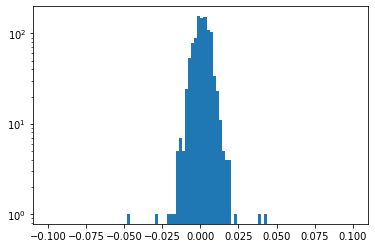

In [47]:
plt.hist(W_out[23, 945], bins=100, log=True, range=(-0.1, 0.1));

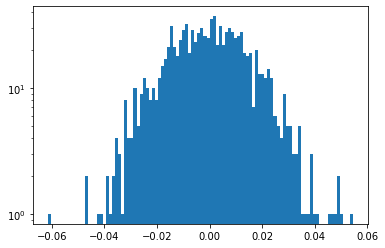

In [60]:
plt.hist(W_out[23, 6], bins=100, log=True);

In [116]:
all_neurons = neuron_data[model_name] + baseline_neuron_data[model_name]
bins = np.linspace(-0.14, 0.14, 200)

composition_counts = {}
for neuron_string in all_neurons:
    layer, neuron = neuron_string.split('.')
    layer = int(layer)
    neuron = int(neuron)
    neuron_activation = W_out_norm[layer, neuron]
    neuron_composition = W_U_norm @ neuron_activation
    n_count, _ = np.histogram(neuron_composition, bins=bins)
    composition_counts[neuron_string] = n_count

weight_decay_penalty = np.linalg.norm(W_out, axis=-1) ** 2 + np.linalg.norm(W_in, axis=-1) ** 2

In [132]:
main_plot_data = get_plot_data(
    neuron_data, model_name, dataset_name, interventions, valid_tokens)
baseline_plot_data = get_plot_data(
    baseline_neuron_data, model_name, dataset_name, interventions, valid_tokens)

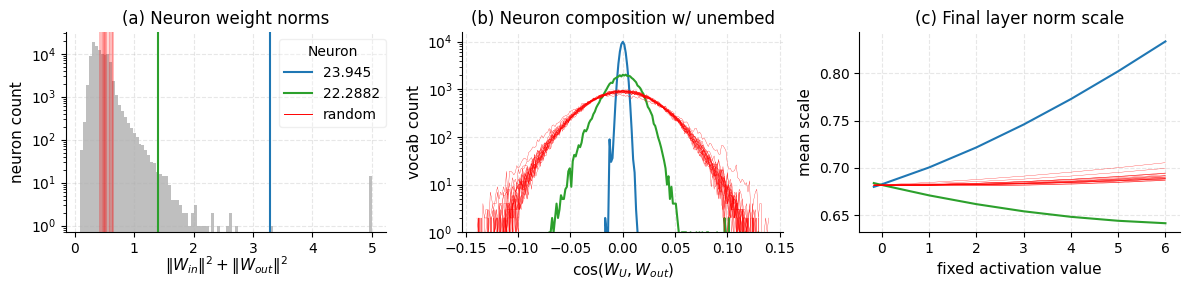

In [145]:
from analysis.entropy_neurons import *

plot_entropy_neuron_weight_info(
    main_plot_data, baseline_plot_data, composition_counts, weight_decay_penalty, 
    bins, activation_values, model_name, neuron_data, baseline_neuron_data
)
plt.savefig('figures/entropy_neuron_weights_main.png', bbox_inches='tight', dpi=200)

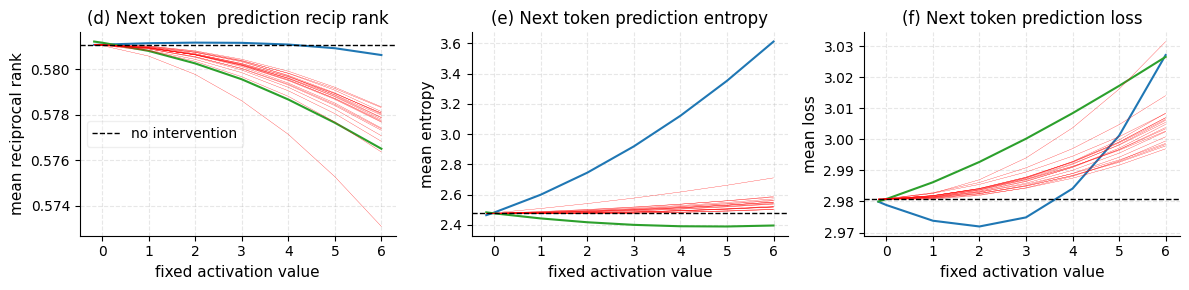

In [147]:
plot_entropy_neuron_intervention(nominal_metrics, main_plot_data, baseline_plot_data, activation_values, neuron_data, baseline_neuron_data, model_name)
plt.savefig('figures/entropy_neuron_intervention_main.png', bbox_inches='tight', dpi=200)

In [158]:
1043677052928 / 2**30

972.0

In [162]:
(24 * 4096 * 24 * 24 * 64) * 4 / 2**30

13.5

In [163]:
(12 * 12 * 64 * 12 * 3072 * 768) * 4 / 2**30

972.0

In [164]:
model

HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0-11): 12 x TransformerBlock(
      (ln1): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_mlp_out): HookPoint()
      (hook_resid_pre): HookPoint()
      

## Figure 1

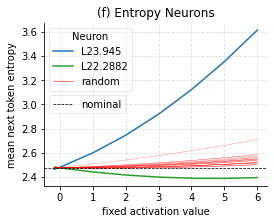

In [101]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(4, 3))

colors = ['tab:blue', 'tab:green']
for ix, neuron in enumerate(neuron_data[model_name]):
    scales = main_plot_data['neuron_entropies'][neuron]
    ax.plot(activation_values, scales, label='L'+neuron, color=colors[ix])

for ix, neuron in enumerate(baseline_neuron_data[model_name]):
    scales = baseline_plot_data['neuron_entropies'][neuron]
    ax.plot(activation_values, scales, color='red', linewidth=0.2)
ax.plot([0, 0.1], [scales[1], scales[1]], color='red', linewidth=0.5, label='random')
#ax.legend(loc='upper left', title='Neuron').get_frame().set_alpha(0.4)

ax.grid(alpha=0.4, linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_title('(f) Entropy Neurons')
ax.set_xlabel('fixed activation value')
ax.set_ylabel('mean next token entropy')


# Existing legend
neuron_legend = ax.legend(loc='upper left', title='Neuron')
neuron_legend.get_frame().set_alpha(0.4)


ax.axhline(nominal_metrics['nominal_entropy'], color='black',
                  linestyle='--', label='none', linewidth=0.75)


nominal_legend_label = 'nominal'
nominal_legend_handle = Line2D([0], [0], color='black', linestyle='--', linewidth=0.75, label=nominal_legend_label)

# New legend for nominal entropy
ax.legend(handles=[nominal_legend_handle], loc='center left').get_frame().set_alpha(0.4) # Adjust the location as needed

# To keep both legends, draw the neuron legend again
ax.add_artist(neuron_legend)

plt.savefig('figures/main_f_entropy.png', bbox_inches='tight', dpi=150)

## GPT2 small

In [61]:
model_name = 'stanford-gpt2-small-a'

model = HookedTransformer.from_pretrained(model_name)

decoded_vocab = {
    tix: model.tokenizer.decode(tix)
    for tix in model.tokenizer.get_vocab().values()
}
nominal_metrics, valid_tokens = get_nominal_metrics(dataset_name, model_name, decoded_vocab)

Using pad_token, but it is not set yet.


Loaded pretrained model stanford-gpt2-small-a into HookedTransformer


In [62]:
W_out = model.W_out.detach().cpu().numpy()
W_in = np.swapaxes(model.W_in.detach().cpu().numpy(), 1, 2)
W_U = model.W_U.detach().cpu().numpy().T 

W_out_norm = W_out / np.linalg.norm(W_out, axis=-1)[:, :, None]
W_in_norm = W_in / np.linalg.norm(W_in, axis=-1)[:, :, None]
W_U_norm = W_U / np.linalg.norm(W_U, axis=-1)[:, None]

Text(0.5, 1.0, 'Histogram of (input) weights for neuron L11.3030')

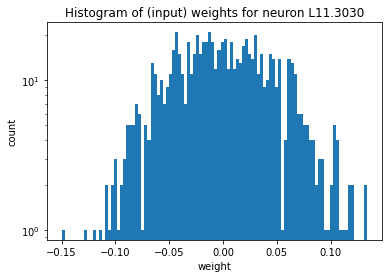

In [68]:
plt.hist(W_in[11, 3030], log=True, bins=100);
plt.xlabel('weight')
plt.ylabel('count')
plt.title('Histogram of (input) weights for neuron L11.3030')

In [156]:
all_neurons = neuron_data[model_name] + baseline_neuron_data[model_name]
bins = np.linspace(-0.2, 0.2, 200)

composition_counts = {}
for neuron_string in all_neurons:
    layer, neuron = neuron_string.split('.')
    layer = int(layer)
    neuron = int(neuron)
    neuron_activation = W_out_norm[layer, neuron]
    neuron_composition = W_U_norm @ neuron_activation
    n_count, _ = np.histogram(neuron_composition, bins=bins)
    composition_counts[neuron_string] = n_count

weight_decay_penalty = np.linalg.norm(W_out, axis=-1) ** 2 + np.linalg.norm(W_in, axis=-1) ** 2

In [151]:
main_plot_data = get_plot_data(
    neuron_data, model_name, dataset_name, interventions, valid_tokens)
baseline_plot_data = get_plot_data(
    baseline_neuron_data, model_name, dataset_name, interventions, valid_tokens)

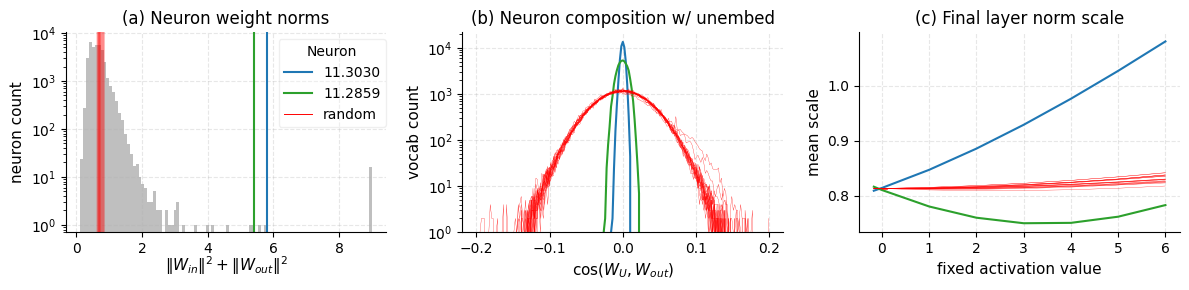

In [157]:
plot_entropy_neuron_weight_info(
    main_plot_data, baseline_plot_data, composition_counts, weight_decay_penalty, 
    bins, activation_values, model_name, neuron_data, baseline_neuron_data, clip_norm=9
)
plt.savefig('figures/entropy_neuron_weights_gpt2_small.png', bbox_inches='tight', dpi=100)

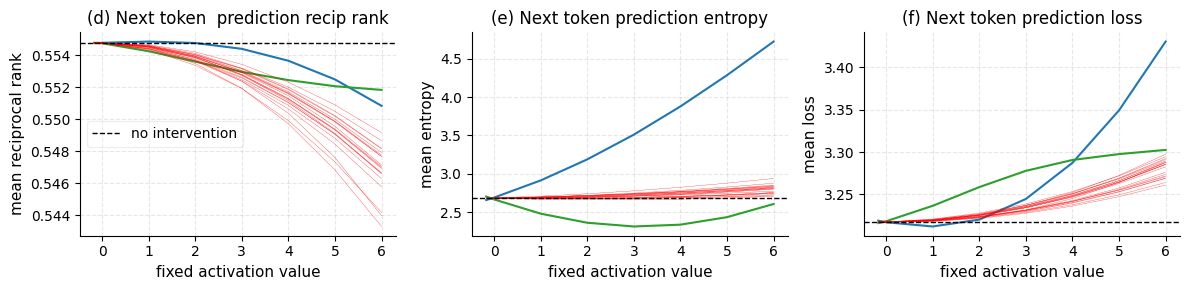

In [153]:
plot_entropy_neuron_intervention(nominal_metrics, main_plot_data, baseline_plot_data, activation_values, neuron_data, baseline_neuron_data, model_name)
plt.savefig('figures/entropy_neuron_intervention_gpt2small.png', bbox_inches='tight', dpi=100)

## Scrap

In [37]:
from summary_viewer import *

weight_summaries = load_weights_summary('stanford-gpt2-small-c')

In [30]:
weight_summaries.keys()

dict_keys(['q_comps', 'k_comps', 'vocab_comps', 'neuron_stats', 'neuron_comps', 'o_comps', 'v_comps'])

In [31]:
weight_summaries['vocab_comps']['U_out']['comp_var'].shape


torch.Size([24, 4096])

In [38]:
weight_summaries['vocab_comps']['U_out']['comp_var'].numpy().flatten().min()

1.4662655e-05

In [39]:
weight_summaries['vocab_comps']['U_out']['comp_var'][11, 2184]

tensor(1.4663e-05)

In [9]:
tokenized_dataset = datasets.load_from_disk(
        os.path.join(
            os.getenv('DATASET_DIR', 'token_datasets'),
            'gpt2',
            'pile.test.all-100k.512'
        )
)

In [10]:
batch = tokenized_dataset['tokens'][:24, :]

In [11]:
def fix_activation(activations, hook, neuron, value):
    activations[:, :, neuron] = value
    return activations

In [19]:
from functools import partial
hooks = [('blocks.23.mlp.hook_post', partial(fix_activation, neuron=945, value=5.0))]
logits = model.run_with_hooks(batch, fwd_hooks=hooks)
model.reset_hooks()

In [17]:
logits.shape

torch.Size([24, 512, 50257])

In [18]:
zero_logits = logits.cpu().numpy().flatten()

In [20]:
five_logits = logits.cpu().numpy().flatten()

In [22]:
import torch.nn.functional as F
zero_probs = F.softmax(torch.tensor(zero_logits).reshape(24, 512, 50257), dim=-1)
five_probs = F.softmax(torch.tensor(five_logits).reshape(24, 512, 50257), dim=-1)
zero_entropies = -torch.sum(zero_probs * torch.log(zero_probs + 1e-8), dim=-1).cpu()
five_entropies = -torch.sum(five_probs * torch.log(five_probs + 1e-8), dim=-1).cpu()



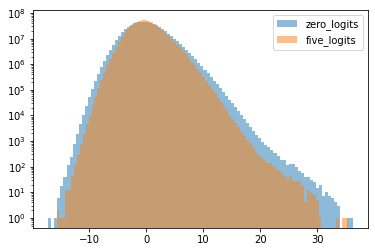

In [21]:
plt.hist(zero_logits, bins=100, alpha=0.5, label='zero_logits')
plt.hist(five_logits, bins=100, alpha=0.5, label='five_logits');
plt.legend()
plt.yscale('log')

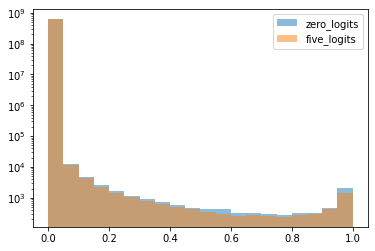

In [24]:
plt.hist(zero_probs.numpy().flatten(), bins=20, alpha=0.5, label='0 intervention')
plt.hist(five_probs.numpy().flatten(), bins=20, alpha=0.5, label='5 intervention');
plt.legend()
plt.yscale('log')
plt.y

In [100]:
torch.tensor(zero_logits).shape

torch.Size([617558016])

In [104]:
zero_entropies

tensor([[5.8477, 7.9190, 7.9565,  ..., 5.8367, 7.0106, 4.3834],
        [5.8477, 3.9544, 5.9531,  ..., 1.4547, 1.6189, 4.2925],
        [5.8477, 4.6397, 1.8598,  ..., 2.4265, 1.1971, 3.8696],
        ...,
        [5.8477, 6.5898, 7.2132,  ..., 0.9993, 3.6138, 0.5075],
        [5.8477, 5.0438, 6.5383,  ..., 3.6708, 5.1840, 0.9465],
        [5.8477, 6.6900, 7.1500,  ..., 2.7078, 1.0539, 4.4886]])

In [103]:
zero_entropies.mean(), five_entropies.mean()

(tensor(2.6087), tensor(3.4402))

In [26]:
zero_save_path = os.path.join(
            'intervention_results', 'stanford-gpt2-medium-a', 'pile.test.all-10m.512', '23.945', 'fixed_activation_0.0')
five_save_path = os.path.join(
            'intervention_results', 'stanford-gpt2-medium-a', 'pile.test.all-10m.512', '23.945', 'fixed_activation_5.0')

In [90]:
save_path

'intervention_results/stanford-gpt2-small-a/pile.test.all-100k.512/11.3030/fixed_activation_0.0'

In [27]:
zero_entropy_tensor = torch.load(os.path.join(zero_save_path, 'entropy.pt'))
five_entropy_tensor = torch.load(os.path.join(five_save_path, 'entropy.pt'))


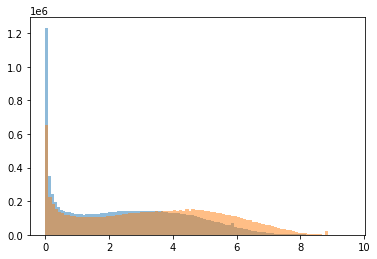

In [96]:
plt.hist(zero_entropy_tensor.numpy().flatten(), alpha=0.5, bins=100, label='zero_entropy');
plt.hist(five_entropy_tensor.numpy().flatten(), alpha=0.5, bins=100, label='five_entropy');

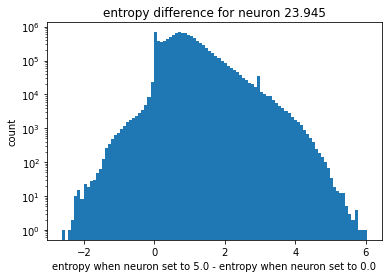

In [30]:
plt.hist((five_entropy_tensor - zero_entropy_tensor).numpy().flatten(), bins=100);
plt.xlabel('entropy when neuron set to 5.0 - entropy when neuron set to 0.0')
plt.ylabel('count')
plt.title('entropy difference for neuron 23.945')
plt.yscale('log')

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
colors = ['tab:blue', 'tab:green']


ax = axs[0]
ax.hist(np.minimum(weight_decay_penalty.flatten(), 5), bins=100, alpha=0.5, color='gray')

for ix, neuron in enumerate(neuron_data[model_name]):
    l, n  = neuron.split('.')
    weight_decay = weight_decay_penalty[int(l), int(n)]
    ax.axvline(weight_decay, alpha=1, color=colors[ix], label=neuron)

for ix, neuron in enumerate(baseline_neuron_data[model_name]):
    l, n  = neuron.split('.')
    weight_decay = weight_decay_penalty[int(l), int(n)] + (int(n) - 2500) / 20000
    ax.axvline(weight_decay, alpha=1, color='red', linewidth=0.2)

ax.plot([1, 2], [-1, -1], color='red', linewidth=0.7, label='random')
# ax.set_xticklabels(['', '0', '1', '2', '3', '4', 'min(5, x)'])
ax.set_yscale('log')
ax.set_ylabel('neuron count')
ax.set_xlabel('$\|W_{in}\|^2 + \|W_{out}\|^2$')
ax.set_title('(a) Neuron weight norms')
ax.set_ylim(bottom=0.7)
ax.legend(title='Neuron', bbox_to_anchor=(1.02, 1), loc='upper right').get_frame().set_alpha(0.3)

ax = axs[1]
bin_mids = (bins[:-1] + bins[1:]) / 2

for ix, neuron in enumerate(neuron_data[model_name]):
    counts = composition_counts[neuron]
    ax.plot(bin_mids, counts, color=colors[ix])

for ix, neuron in enumerate(baseline_neuron_data[model_name]):
    counts = composition_counts[neuron]
    ax.plot(bin_mids, counts, color='red', linewidth=0.2)

ax.set_yscale('log')
ax.set_ylim(bottom=1)

ax.set_ylabel('vocab count')
ax.set_xlabel('$\cos(W_U, W_{out})$')
ax.set_title('(b) Neuron composition w/ unembed')

    # reduce padding between x label and plot
axs[0].xaxis.labelpad = -1
    
ax = axs[2]

for ix, neuron in enumerate(neuron_data[model_name]):
    scales = main_plot_data['neuron_scales'][neuron]
    ax.plot(activation_values, scales, label='L'+neuron, color=colors[ix])

for ix, neuron in enumerate(baseline_neuron_data[model_name]):
    scales = baseline_plot_data['neuron_scales'][neuron]
    ax.plot(activation_values, scales, color='red', linewidth=0.2)
ax.plot([0, 0.1], [scales[1], scales[1]], color='red', linewidth=0.5, label='random')
ax.set_title('(c) Final layer norm scale')
ax.set_xlabel('fixed activation value')
ax.set_ylabel('mean scale')

for ax in axs:
    # turn off top and right borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(alpha=0.3, linestyle='--')

    ax.xaxis.label.set_size(11)
    ax.yaxis.label.set_size(11)

plt.tight_layout()